In [2]:
from transformers import AutoTokenizer, AutoModel
import torch
import torchvision.transforms as T
from PIL import Image
import os
from torchvision.transforms.functional import InterpolationMode

os.environ["CUDA_VISIBLE_DEVICES"] = '0'

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)


def build_transform(input_size):
    MEAN, STD = IMAGENET_MEAN, IMAGENET_STD
    transform = T.Compose([
        T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
        T.Resize((input_size, input_size), interpolation=InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=MEAN, std=STD)
    ])
    return transform


def find_closest_aspect_ratio(aspect_ratio, target_ratios, width, height, image_size):
    best_ratio_diff = float('inf')
    best_ratio = (1, 1)
    area = width * height
    for ratio in target_ratios:
        target_aspect_ratio = ratio[0] / ratio[1]
        ratio_diff = abs(aspect_ratio - target_aspect_ratio)
        if ratio_diff < best_ratio_diff:
            best_ratio_diff = ratio_diff
            best_ratio = ratio
        elif ratio_diff == best_ratio_diff:
            if area > 0.5 * image_size * image_size * ratio[0] * ratio[1]:
                best_ratio = ratio
    return best_ratio


def dynamic_preprocess(image, min_num=1, max_num=6, image_size=448, use_thumbnail=False):
    orig_width, orig_height = image.size
    aspect_ratio = orig_width / orig_height

    # calculate the existing image aspect ratio
    target_ratios = set(
        (i, j) for n in range(min_num, max_num + 1) for i in range(1, n + 1) for j in range(1, n + 1) if
        i * j <= max_num and i * j >= min_num)
    target_ratios = sorted(target_ratios, key=lambda x: x[0] * x[1])

    # find the closest aspect ratio to the target
    target_aspect_ratio = find_closest_aspect_ratio(
        aspect_ratio, target_ratios, orig_width, orig_height, image_size)

    # calculate the target width and height
    target_width = image_size * target_aspect_ratio[0]
    target_height = image_size * target_aspect_ratio[1]
    blocks = target_aspect_ratio[0] * target_aspect_ratio[1]

    # resize the image
    resized_img = image.resize((target_width, target_height))
    processed_images = []
    for i in range(blocks):
        box = (
            (i % (target_width // image_size)) * image_size,
            (i // (target_width // image_size)) * image_size,
            ((i % (target_width // image_size)) + 1) * image_size,
            ((i // (target_width // image_size)) + 1) * image_size
        )
        # split the image
        split_img = resized_img.crop(box)
        processed_images.append(split_img)
    assert len(processed_images) == blocks
    if use_thumbnail and len(processed_images) != 1:
        thumbnail_img = image.resize((image_size, image_size))
        processed_images.append(thumbnail_img)
    return processed_images


def load_image(image_file, input_size=448, max_num=6):
    image = Image.open(image_file).convert('RGB')
    transform = build_transform(input_size=input_size)
    images = dynamic_preprocess(image, image_size=input_size, use_thumbnail=True, max_num=max_num)
    pixel_values = [transform(image) for image in images]
    pixel_values = torch.stack(pixel_values)
    return pixel_values

In [3]:
path = "/data2/renyw/PythonWorkspace/InternVL/pretrained/seven_task_internvl1_5_vit_mlp_lora"
model = AutoModel.from_pretrained(
    path,
    torch_dtype=torch.bfloat16,
    low_cpu_mem_usage=True,
    trust_remote_code=True).eval().cuda()

tokenizer = AutoTokenizer.from_pretrained(path, trust_remote_code=True)

Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  5.34it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
generation_config = dict(
    num_beams=1,
    max_new_tokens=512,
    do_sample=False,
)

torch.Size([1, 3, 448, 448])


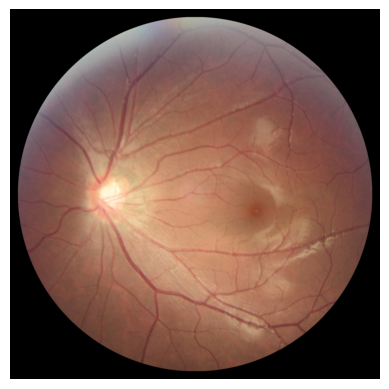

In [20]:
img_path = 'xxx/img_name'
pixel_values = load_image(img_path, max_num=1).to(torch.bfloat16).cuda()
print(pixel_values.shape)
from PIL import Image
from matplotlib import pyplot as plt
image = Image.open(img_path)
plt.axis('off')
plt.imshow(image)

In [6]:
question = 'Hello, how are you?'
response, history = model.chat(tokenizer, None, question, generation_config, history=None, return_history=True)
print(response)

You are not running the flash-attention implementation, expect numerical differences.


Hello! I'm just a computer program, so I don't have feelings or emotions like humans do. But I'm here to help you with any questions you have. How can I assist you today?


In [8]:
question = "What is the quality grade of this fundus image?Good\nUsable\nReject. Please answer the question based on the options mentioned before."
response, history = model.chat(tokenizer, pixel_values, question, generation_config, history=None, return_history=True)
print(response)

Good


In [10]:
question = "What is the level of diabetic retinopathy? Answer the question using a single word or phrase."
response, history = model.chat(tokenizer, pixel_values, question, generation_config, history=None, return_history=True)
print(response)

no dr


In [ ]:
question = "Please provide the bounding box coordinate of the region this sentence describes: <ref>Optic Disk</ref>"
response, history = model.chat(tokenizer, pixel_values, question, generation_config, history=None, return_history=True)
print(response)

question = "Please provide the bounding box coordinate of the region this sentence describes: <ref>Optic Cup</ref>"
response, history = model.chat(tokenizer, pixel_values, question, generation_config, history=None, return_history=True)
print(response)

Optic Disk [[0.2061, 0.4421, 0.3219, 0.5732]]
Optic Cup [[0.2341, 0.4688, 0.3011, 0.5381]]


In [9]:
question = "Imagine you are a senior medical expert specializing in fundus image analysis. Describe the image."
response, history = model.chat(tokenizer, pixel_values, question, generation_config, history=None, return_history=True)
print(response)

The image shows a fundus photograph of a healthy retina, indicating no signs of diabetic retinopathy or referable diabetic macular edema. The retinal vessels appear normal, with no evidence of hemorrhages, exudates, or microaneurysms. The optic disc is well-defined, and the macula appears intact without any signs of swelling or hard exudates.
